<a href="https://colab.research.google.com/github/kaushal-malpure/Using-Deep-RL-to-optimize-Stock-Trading-Strategy/blob/main/Midterm_2024.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import gym
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
import random
from collections import deque
import matplotlib.pyplot as plt
from IPython.display import clear_output

In [ ]:
# Define the DQN model
class DQN(nn.Module):
    def __init__(self, state_size, action_size):
        super(DQN, self).__init__()
        self.fc1 = nn.Linear(state_size, 64)
        self.fc2 = nn.Linear(64, 64)
        self.fc3 = nn.Linear(64, action_size)

    def forward(self, x):
        x = torch.relu(self.fc1(x))
        x = torch.relu(self.fc2(x))
        return self.fc3(x)

# Hyperparameters
BATCH_SIZE = 64
GAMMA = 0.99
EPSILON_START = 1.0
EPSILON_END = 0.01
EPSILON_DECAY = 0.995
LEARNING_RATE = 0.001
MEMORY_SIZE = 10000
TARGET_UPDATE = 10

In [ ]:
# Environment setup
env = gym.make('CartPole-v1')
state_size = env.observation_space.shape[0]
action_size = env.action_space.n
print(state_size, action_size)

4 2


/usr/local/lib/python3.10/dist-packages/gym/core.py:317: DeprecationWarning: WARN: Initializing wrapper in old step API which returns one bool instead of two. It is recommended to set `new_step_api=True` to use new step API. This will be the default behaviour in future.
  deprecation(
/usr/local/lib/python3.10/dist-packages/gym/wrappers/step_api_compatibility.py:39: DeprecationWarning: WARN: Initializing environment in old step API which returns one bool instead of two. It is recommended to set `new_step_api=True` to use new step API. This will be the default behaviour in future.
  deprecation(


In [ ]:
# Initialize DQN and target network
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
policy_net = DQN(state_size, action_size).to(device)
target_net = DQN(state_size, action_size).to(device)
target_net.load_state_dict(policy_net.state_dict())
target_net.eval()

DQN(
  (fc1): Linear(in_features=4, out_features=64, bias=True)
  (fc2): Linear(in_features=64, out_features=64, bias=True)
  (fc3): Linear(in_features=64, out_features=2, bias=True)
)

In [ ]:
# Setup optimizer
optimizer = optim.Adam(policy_net.parameters(), lr=LEARNING_RATE)

# Initialize replay memory
memory = deque(maxlen=MEMORY_SIZE)

In [ ]:
# Training function
def train():
    if len(memory) < BATCH_SIZE:
        return

    batch = random.sample(memory, BATCH_SIZE)
    states, actions, rewards, next_states, dones = zip(*batch)

    states = torch.FloatTensor(states).to(device)
    actions = torch.LongTensor(actions).to(device)
    rewards = torch.FloatTensor(rewards).to(device)
    next_states = torch.FloatTensor(next_states).to(device)
    dones = torch.BoolTensor(dones).to(device)

    current_q_values = policy_net(states).gather(1, actions.unsqueeze(1))
    next_q_values = target_net(next_states).max(1)[0].detach()
    target_q_values = rewards + GAMMA * next_q_values * (~dones)

    loss = nn.MSELoss()(current_q_values, target_q_values.unsqueeze(1))

    optimizer.zero_grad()
    loss.backward()
    optimizer.step()


In [ ]:
# Plotting function
def plot_results(episode_rewards, episode_lengths, avg_rewards, epsilon_values):
    clear_output(True)
    plt.figure(figsize=(20, 10))

    plt.subplot(221)
    plt.plot(episode_rewards)
    plt.title('Episode Rewards')
    plt.xlabel('Episode')
    plt.ylabel('Reward')

    plt.subplot(222)
    plt.plot(episode_lengths)
    plt.title('Episode Lengths')
    plt.xlabel('Episode')
    plt.ylabel('Length')

    plt.subplot(223)
    plt.plot(avg_rewards)
    plt.title('Average Reward (last 100 episodes)')
    plt.xlabel('Episode')
    plt.ylabel('Average Reward')

    plt.subplot(224)
    plt.plot(epsilon_values)
    plt.title('Epsilon Values')
    plt.xlabel('Episode')
    plt.ylabel('Epsilon')

    plt.tight_layout()
    plt.show()


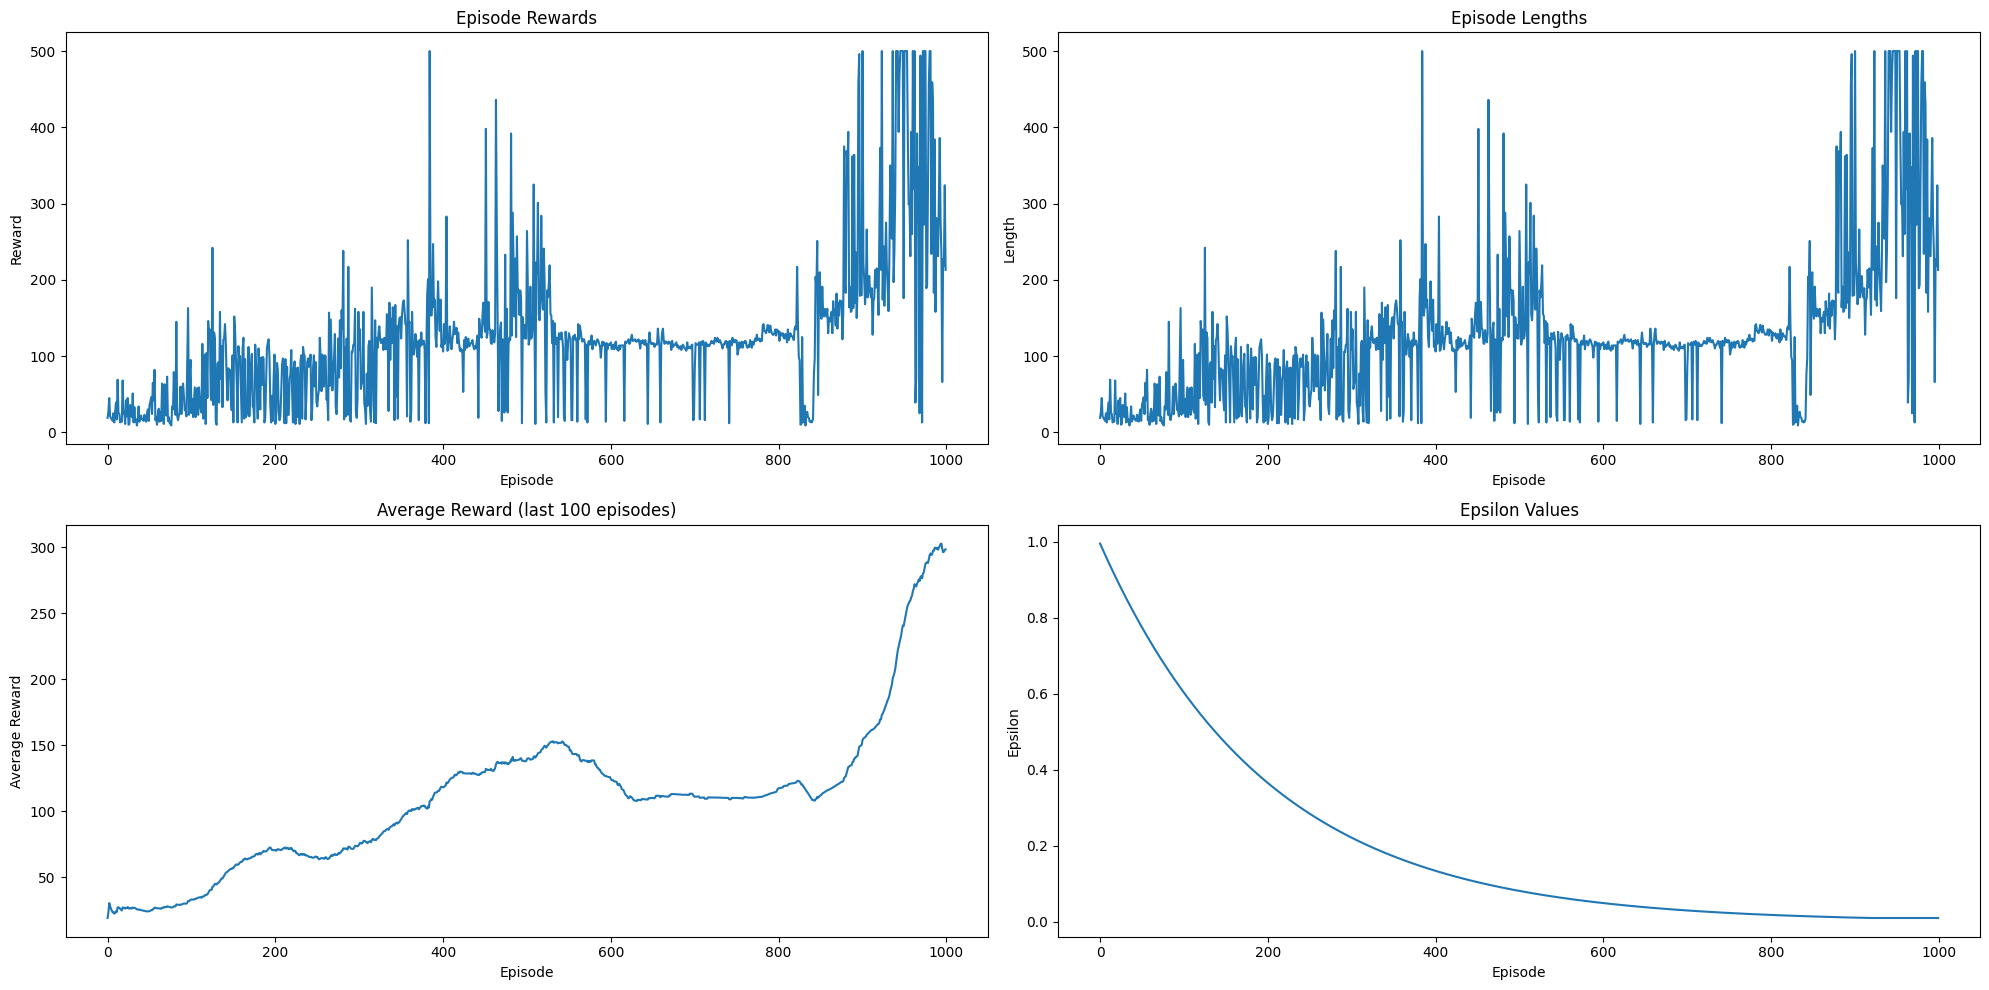

In [ ]:
# Main training loop
epsilon = EPSILON_START
episodes = 1000

episode_rewards = []
episode_lengths = []
avg_rewards = []
epsilon_values = []

for episode in range(episodes):
    state = env.reset()
    done = False
    total_reward = 0
    steps = 0

    while not done:
        if random.random() < epsilon:
            action = env.action_space.sample()
        else:
            with torch.no_grad():
                action = policy_net(torch.FloatTensor(state).to(device)).argmax().item()

        next_state, reward, done, _ = env.step(action)
        memory.append((state, action, reward, next_state, done))
        state = next_state
        total_reward += reward
        steps += 1

        train()

    epsilon = max(EPSILON_END, epsilon * EPSILON_DECAY)

    if episode % TARGET_UPDATE == 0:
        target_net.load_state_dict(policy_net.state_dict())

    # Logging
    episode_rewards.append(total_reward)
    episode_lengths.append(steps)
    avg_rewards.append(np.mean(episode_rewards[-100:]))
    epsilon_values.append(epsilon)

    print(f"Episode {episode + 1}, Total Reward: {total_reward}, Length: {steps}, Epsilon: {epsilon:.2f}")

    # Plotting (every 10 episodes)
    if (episode + 1) % 10 == 0:
        plot_results(episode_rewards, episode_lengths, avg_rewards, epsilon_values)

env.close()

# Final plot
plot_results(episode_rewards, episode_lengths, avg_rewards, epsilon_values)

# Save the trained model
torch.save(policy_net.state_dict(), 'dqn_inverted_pendulum.pth')